In [15]:
#Load Libraries
import numpy as np
import pandas as pd
import tkinter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
cancer=pd.read_csv('./cancer.csv')
cancer.head()

,id,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
#Remove id Column
df=cancer.drop('id',axis=1)
df.head()

,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [5]:
#Create Profile Report
 
#Importing package
import pandas_profiling as pp
from IPython.display import IFrame
 
# Profile Report
CancerReport = pp.ProfileReport(df)
CancerReport.to_file('CancerReport.html')
display(IFrame('CancerReport.html', width=900, height=350))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#Class Balance
print('Class Split')
print(df['Class'].value_counts())
df['Class'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

Class Split
2    444
4    239
Name: Class, dtype: int64


Text(0, 0.5, 'Count')

In [8]:
#Create x and y variables
x = df.drop('Class', axis=1).to_numpy()
Y = df['Class'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.transform(x_test)

#Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [10]:
#Class Balance - Test Data
print('Train Data - Class Split')
num_zeros = (y_train_smt == 2).sum()
num_ones = (y_train_smt == 4).sum()
print('Class 2 -',  num_zeros)
print('Class 4 -',  num_ones)

Train Data - Class Split
Class 2 - 355
Class 4 - 355


In [11]:
#Base LDA, QDA and Logistical Regression Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('LDA', LinearDiscriminantAnalysis()),('QDA',QuadraticDiscriminantAnalysis()),
                   ('LogReg',LogisticRegression(solver='liblinear',
                                               class_weight='balanced',
                                               random_state=100))]: 
    method.fit(x_train2,y_train_smt)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))         


Estimator: LDA
[[89  0]
 [ 3 45]]
              precision    recall  f1-score   support

           2       0.97      1.00      0.98        89
           4       1.00      0.94      0.97        48

    accuracy                           0.98       137
   macro avg       0.98      0.97      0.98       137
weighted avg       0.98      0.98      0.98       137


Estimator: QDA
[[85  4]
 [ 1 47]]
              precision    recall  f1-score   support

           2       0.99      0.96      0.97        89
           4       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137


Estimator: LogReg
[[89  0]
 [ 3 45]]
              precision    recall  f1-score   support

           2       0.97      1.00      0.98        89
           4       1.00      0.94      0.97        48

    accuracy                           0.98       137
   macro avg       0

In [12]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_lda = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearDiscriminantAnalysis())])
pipeline.insert(0,pipe_lda)

pipe_qda = Pipeline([('scl', StandardScaler()),
                    ('clf', QuadraticDiscriminantAnalysis())])
pipeline.insert(1,pipe_qda)

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear',
                                               class_weight='balanced',
                                               random_state=100))])   
pipeline.insert(2,pipe_logreg)
    
    
# Set grid search params 

modelpara =[]

param_gridlda = {'clf__solver':['svd','lsqr','eigen']}
modelpara.insert(0,param_gridlda)

param_gridqda = {}
modelpara.insert(1,param_gridqda)

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(2,param_gridlogreg)

In [13]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_smt, 
                                                            y=y_train_smt,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.6, 1.0])
    plt.show()

LDA Learning Curve


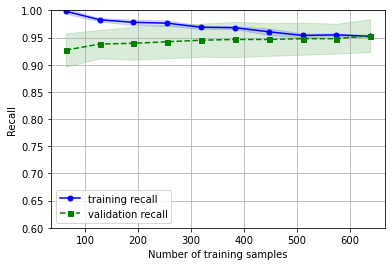


 QDA Learning Curve


C:\Users\ramse\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


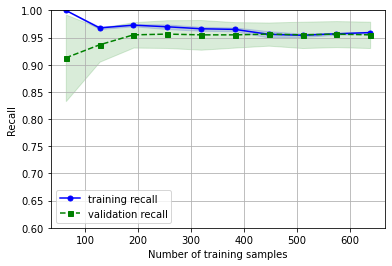


 Logistic Regression Learning Curve


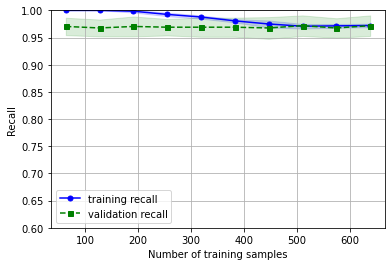

In [16]:
#Plot Learning Curve
print('LDA Learning Curve')
plot_learning_curves(pipe_lda)
print('\n QDA Learning Curve')
plot_learning_curves(pipe_qda)
print('\n Logistic Regression Learning Curve')
plot_learning_curves(pipe_logreg)

Model Evaluation - Recall Score
LDA 0.96 +/- 0.02
QDA 0.95 +/- 0.03
Log Reg 0.97 +/- 0.02




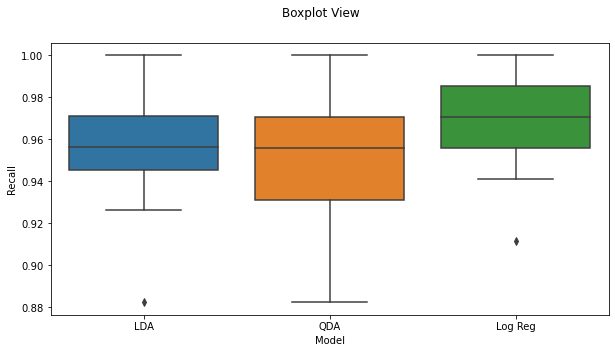

In [17]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LDA',pipe_lda))
models.append(('QDA',pipe_qda))
models.append(('Log Reg',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,Y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n') 

fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [18]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_smt, y_train_smt)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Validation Statistics
    target_names=['Class 2','Class 4']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LinearDiscriminantAnalysis()

Best Parameters: {'clf__solver': 'svd'}

 [[89  0]
 [ 3 45]]

               precision    recall  f1-score   support

     Class 2       0.97      1.00      0.98        89
     Class 4       1.00      0.94      0.97        48

    accuracy                           0.98       137
   macro avg       0.98      0.97      0.98       137
weighted avg       0.98      0.98      0.98       137

ROC Curve


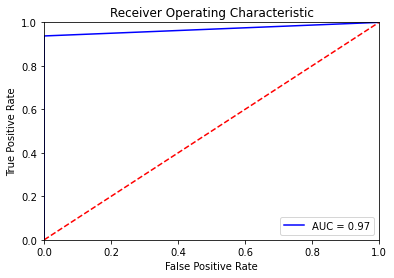


Optimized Model

Model Name: QuadraticDiscriminantAnalysis()

Best Parameters: {}

 [[85  4]
 [ 1 47]]

               precision    recall  f1-score   support

     Class 2       0.99      0.96      0.97        89
     Class 4       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137

ROC Curve


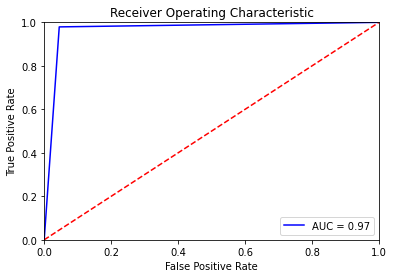


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100,
                   solver='liblinear')

Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2'}

 [[89  0]
 [ 2 46]]

               precision    recall  f1-score   support

     Class 2       0.98      1.00      0.99        89
     Class 4       1.00      0.96      0.98        48

    accuracy                           0.99       137
   macro avg       0.99      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137

ROC Curve


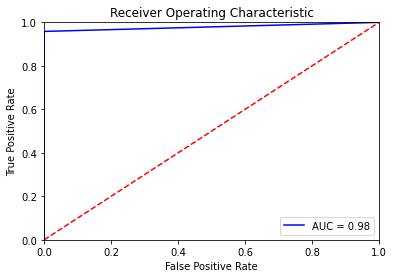

In [19]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)